## Programming Exercise 4: Neural Networks Learning

Welcome to programming exrecise 4, Neural Network Learning. In this exercise, we shall implement the backpropagation algorithm for neural networks and apply it to the task of `hand-written digit recognition`. 

**Instruction:**
- To run code a cell: `Shift+Enter` or Click `Cell -> Run Cell`.

**Objective:**
- To implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition

**You will learn how to:**
- Implement a 10-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as sigmoid
- Implement forward and backward propagation

## Import packages ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python
- [matplotlib](http://matplotlib.org) is a common library to plot graphs in python.
- [scipy](https://docs.scipy.org/doc/scipy-0.17.0/reference/optimize.html) a python library for optimization functions.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import scipy.io as sio

# For data plots and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

## 1 - Loading and visualizing part of dataset##

**1.1 - Loading the dataset**

The training data will be loaded into the variables `X_train` and `y_train`.

In [2]:
#IMPORTING DATA FILES
df_path = 'data/ex4data1.mat'
data = sio.loadmat(df_path)
X_train = data['X']
y_train = data['y']

# RESULTS CHECK
print('\ni. Training features[X_train]:\n\tRows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('ii. Training labels[y_train]:\n\tRows: %d, columns: %d' % (y_train.shape[0], y_train.shape[1]))


i. Training features[X_train]:
	Rows: 5000, columns: 400
ii. Training labels[y_train]:
	Rows: 5000, columns: 1


**1.2 - Visualizing sampled digits from dataset**

In [3]:
# VISUALIZING THE DATA SET
def visualizeData(x):
    fig, ax = plt.subplots(nrows =5, ncols=5,sharex=True, sharey=True)
    ax = ax.flatten()
    m = x.shape[0]
    for i in range(25):
        img = x[np.random.randint(0,m),:].reshape(20,20,order="F")
        ax[i].imshow(img, cmap=mpl.cm.binary, interpolation="nearest")
        ax[i].axis("on")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

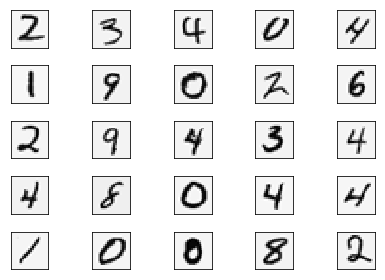

In [4]:
visualizeData(X_train) # calling the function to vidsualize the dataset.

## 2 - Neural Network Model

Our neural network is as shown in the model representation below. It has `3 layers` - an `input layer`, a `hidden layer` and an `output layer`.

![nn_model_representation](images/nn_model_representation.png)

We have been provided with a set of pre-trained network parameters. These are stored in `./data/ex4weights.mat` and we need to load them into `W1` and `W2`. The parameters have dimensions that are sized for a neural network with `25 units` in the second layer and `10 output units` (corresponding to the 10 digit classes).

In [5]:
# Load the weights into variables W1 and W2
df = 'data/ex4weights.mat'
weights = sio.loadmat(df)
W1 = weights['Theta1']
W2 = weights['Theta2']
W1_flat = W1.flatten()
W2_flat = W2.flatten()

# Unroll the loaded parameters
nn_weights = np.concatenate((W1_flat,W2_flat),axis=0).reshape(-1,1) #Alternatively unrolling
print('\nNeural Network Parameters Successfully Loaded ...\n')


Neural Network Parameters Successfully Loaded ...



Let us check the parameter shapes.

In [6]:
print('W1: ', W1.shape)
print('W2: ', W2.shape)
print('NN_WEIGHTS: ', nn_weights.shape)

W1:  (25, 401)
W2:  (10, 26)
NN_WEIGHTS:  (10285, 1)


Recall that our inputs are pixel values of digit images. Since the images are of size 20x20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1).

**2.1 - NN Layer sizes**

In [7]:
# NETWORK MODEL SETTINGS FOR THE EXERCISE
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

**2.2 - Initializing parameters**

We need to implement the function `initialize_parameters()` that we shall use to initialize parameters for out network.

In [8]:
def initialize_parameters(nn_weights, input_layer_size, hidden_layer_size, num_labels):
    # -------------------------------------------------------------
    # Reshaping W1 and W2
    # -------------------------------------------------------------
    W1 = np.reshape(nn_weights[0:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)));
    W2 = np.reshape(nn_weights[(hidden_layer_size * (input_layer_size + 1)):,], (num_labels, (hidden_layer_size + 1)));
    
    assert (W1.shape == (hidden_layer_size, input_layer_size + 1))
    assert (W2.shape == (num_labels, hidden_layer_size + 1))

    parameters = {"W1":W1,
                  "W2":W2}
    
    return parameters

In [9]:
parameters = initialize_parameters(nn_weights, input_layer_size, hidden_layer_size, num_labels);

W1 = parameters["W1"]
W2 = parameters["W2"]

print('The shape of X is: ' + str(X_train.shape))
print('The shape of Y is: ' + str(y_train.shape))
print('The shape of W1 is: ' + str(W1.shape))
print('The shape of W2 is: ' + str(W2.shape))

The shape of X is: (5000, 400)
The shape of Y is: (5000, 1)
The shape of W1 is: (25, 401)
The shape of W2 is: (10, 26)


**2.3 - Sigmoid & `sigmoid-gradient` functions**

Considering that in this exercise we are using the `sigmoid function` as an activation function. We need to implement the function `sigmoid()`.

**2.3.1 - Sigmoid function**

In [10]:
def sigmoid(z):
    return (1/(1+ np.exp(-z)))

**2.3.2 - Gradient of sigmoid function**

In [11]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z),(1 - sigmoid(z)))

**2.3.3 - Evaluating sigmoid gradient function**

In [12]:
print('\nEvaluating sigmoid gradient...\n')
z = np.array([[-1, -0.5, 0, 0.5, 1]]);
g = sigmoidGradient(z);
print('\nComputed gradients for Z:',str(g)+'\n');
print('\nGradient at [z = 0]:',str(g[0,2])+'\n');


Evaluating sigmoid gradient...


Computed gradients for Z: [[0.19661193 0.23500371 0.25       0.23500371 0.19661193]]


Gradient at [z = 0]: 0.25



**2.4 - Feed forward implementation**

We implement the forward propagation by following the steps below:

- **Step 1:** Add a column of ones (bias, $x_0^{(1)}$) at index 0 of the input X. Call the resultant, **A1**.

        - A1 = np.insert(X,0,1,axis=1);
- **Step 2:** Multiply A1 with the transpose of W1, call the resultant, Z2
    
        - Z2 = np.dot(A1,W1.T);
 
- **Step 3:** Compute activations **A2** by first applying the sigmoid function to Z2 then Add a column of one (bias, $x_0^{(2)}$ at index 0.
 
        - A2=np.insert(sigmoid(Z2),0,1,axis=1)
        
- **Step 4:** Compute **Z3** by multiplying the **A2** and the transpose of W2.

        - Z3= np.dot(A2,W2.T);
 
- **Step 5:** Compute the activations in outer layer by computing the sigmoid of Z3.

        - A3=sigmoid(Z3);

In [13]:
def feedForward(X, parameters):
    
    # -------------------------------------------------------------
    # Retrieving parameters
    # -------------------------------------------------------------
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    m = X.shape[0];
        
    # -------------------------------------------------------------
    # The Forward Propagation Implementation
    # -------------------------------------------------------------
    A1 = np.insert(X,0,1,axis=1);           # X.shape = (5000 x 401)
    Z2 = np.dot(A1,W1.T);                   # Z1.shape = (5000 x 401).(401 x 25)= (5000 x 25)
    A2=np.insert(sigmoid(Z2),0,1,axis=1);   # A1.shape = (5000x26)
    Z3= np.dot(A2,W2.T);                    # Z2.shape = (5000 x26) . (26x10) =  (5000 x 10)
    A3=sigmoid(Z3);                         # A2.shape = (5000 x 10)
    
    # -------------------------------------------------------------
    # SAVING THE ACTIVATIONS TO DICTIONARY
    # -------------------------------------------------------------
    cache = {"A1":A1,
             "Z2":Z2, 
             "A2":A2, 
             "Z3":Z3,
             "A3":A3}

    return A3, cache

**2.5 - Neural network cost function**

The cost function for neural networks with regularization is given by:

![nn_cost_fucntion](images/nn_cost_function.png)

In this exercise, we assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, implement out code in such a way that it should work for any number of input units, hidden units and outputs units.

In [14]:
def nnCostFunction(A3, Y, parameters,Lambda):
    
    # -------------------------------------------------------------
    # Retrieving parameters
    # -------------------------------------------------------------
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    m = Y.shape[0]
    # -------------------------------------------------------------
    # Mapping vector y into a binary vector of 1's and 0's 
    # -------------------------------------------------------------
    y_matrix = np.zeros((m, num_labels)) #y_matrix.shape = (5000x10)
    for i in range(m):
        y_matrix[i, Y[i] - 1] = 1
    
    # -------------------------------------------------------------
    # The Cost Implementation
    # -------------------------------------------------------------
    reg_term = (Lambda/(2*m)) * (np.sum(np.sum(np.square(W1[:,1:]))) + np.sum(np.sum(np.square(W2[:,1:])))); 
    cost = ((1/m * np.sum(np.sum((np.multiply(-y_matrix,np.log(A3))- np.multiply((1-y_matrix),np.log(1-A3)))))) + reg_term);
    
    return cost

In [15]:
Lambda = 0 #No regularisation
A3, cache = feedForward(X_train,parameters)
cost = nnCostFunction(A3, y_train, parameters, Lambda)
print('\nCost at parameters (loaded from ex4weights): %.6f\n' % (cost));


Cost at parameters (loaded from ex4weights): 0.287629



In [16]:
Lambda = 1 #With regularisation
A3, cache = feedForward(X_train,parameters)
cost = nnCostFunction(A3, y_train, parameters, Lambda)
print('\nCost at parameters (loaded from ex4weights): %.6f\n' % (cost));


Cost at parameters (loaded from ex4weights): 0.383770



**2.6 - Random Initialization**

Training neural networks requires random initialization of the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range [$-\epsilon_{init}, \epsilon_{init}$] where  $\epsilon_{init}$ is given by:

$$\epsilon_{init} = \frac {\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$$

 .. where ${L_{in} = s_l}$ and ${L_{out} = s_{l+1}}$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

In [17]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in));
    epsilon_init = np.sqrt(6)/np.sqrt(L_in + L_out);
    W = np.random.randn(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;
    
    return W

Now, let us initialize `initial_W1` $\Theta^{(l)}$  and `initial_W2` $\Theta^{(2)}$ using the `randInitializeWeights()` we just implemented.

In [18]:
# Initializing NN Weights
print('\nInitializing Neural Network Parameters ...\n')
initial_W1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_W2 = randInitializeWeights(hidden_layer_size, num_labels);

# Unroll parameters
initial_nn_params = np.concatenate((initial_W1.flatten(),initial_W2.flatten()),axis=0).reshape(-1,1)

#RESULTS CHECK
print('Shape of initial_W1 is: ', initial_W1.shape)
print('Shape of initial_W2 is: ', initial_W2.shape)
print('Shape of nn_params is: ', initial_nn_params.shape)


Initializing Neural Network Parameters ...

Shape of initial_W1 is:  (25, 401)
Shape of initial_W2 is:  (10, 26)
Shape of nn_params is:  (10285, 1)


**2.7 - Backpropagation Implementation**

Now, we will implement the backpropagation algorithm. 

![nn_back_propagation](images/nn_back_propagation.png)

In [19]:
def backward_propagation(parameters, cache, x, y, Lambda, learning_rate):
    # -------------------------------------------------------------
    # Retrieving parameters
    # -------------------------------------------------------------
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # -------------------------------------------------------------
    # Retrieving cache parameters
    # -------------------------------------------------------------
    A1 = cache["A1"]
    Z2 = cache["Z2"]
    A2 = cache["A2"]
    Z3 = cache["Z3"]
    A3 = cache["A3"]
    
    # -------------------------------------------------------------
    # Mapping vector y into a binary vector of 1's and 0's 
    # -------------------------------------------------------------
    m = x.shape[0];
    y_matrix = np.zeros((m, num_labels))
    for i in range(m):
        y_matrix[i, y[i] - 1] = 1

    # -------------------------------------------------------------
    # Backpropagation algorithm
    # -------------------------------------------------------------
    d3 = A3-y_matrix;                               #dZ2.shape = (5000x10)
    u = sigmoid(Z2);                                #u.shape = (5000 x 25)
    sig_grad = np.multiply(u,(1-u))                 #(5000 x 25)
    d2 = np.multiply(np.dot(d3, W2[:,1:]),sig_grad) # d2.shape = (5000x25)
    delta1 = np.dot(d2.T,A1)                        # delta1.shape = (25x5000).(5000 x 401)
    delta2 = np.dot(d3.T,A2)                        # delta2.shape = (10x5000).(5000 x 26)
    temp1=W1; #
    temp2=W2;
    temp1[:,0]=0;
    temp2[:,0]=0;
    dW1 = (1/m * delta1) + ((Lambda/m) * temp1)
    dW2 = (1/m * delta2) + ((Lambda/m) * temp2)
    
    # -------------------------------------------------------------
    # Update parameters
    # -------------------------------------------------------------
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    
    
    parameters = {"W1":W1,
                  "W2":W2}
    
    return parameters

**2.8 - Neural Network Model**

At this stage  of the exercise, we have all functions we need to implement a model. Therefore, in this section, we implement a `nn_model()` function for training our model. The `nn_model()` returns the trained `parameters` by our model.

In [20]:
def nn_model(X,Y, initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Lambda, learning_rate, print_cost=False):
    
    parameters = initialize_parameters(initial_nn_params, input_layer_size, hidden_layer_size, num_labels)
        
    # -------------------------------------------------------------
    # Retrieving parameters
    # -------------------------------------------------------------
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    m = X.shape[0]
    cost_vec = [] # To store cost values per iterations
    
    for i in range((m)):
        A3, cache = feedForward(X,parameters)
        cost = nnCostFunction(A3, Y, parameters, Lambda)
        cost_vec.append(cost)
        parameters = backward_propagation(parameters, cache, X, Y, Lambda, learning_rate)
        if print_cost and i % 1000 ==0:
            print("Iteration %i: Cost:%f"%(i,cost))
    
    return parameters, np.array(cost_vec)

Now we can call the `nn_model()` to train it with specified hyperparameter settings.

In [21]:
parameters, cost_vec = nn_model(X_train,y_train,
                      initial_nn_params, 
                      input_layer_size, 
                      hidden_layer_size, 
                      num_labels, 
                      Lambda=1, 
                      learning_rate=1, print_cost=True)

Iteration 0: Cost:5.743477
Iteration 1000: Cost:0.587566
Iteration 2000: Cost:0.481769
Iteration 3000: Cost:0.435187
Iteration 4000: Cost:0.410854


**2.9.1 - NN Learning curve**

In [22]:
def nnLearningCurve(cost_vec):
    #plt.figure(figsize=(10,8)) #IF YOU WANT TO RESIZE THE FIGURE SIZE REMOVE THE HASHTAG CHARACTER
    plt.plot(range(len(cost_vec)),cost_vec,'b-o', label= r'${J{(\theta)}}$')
    plt.grid(True)
    plt.title("Neural Network cost convergence graph")
    plt.xlabel('# of Iterations')
    plt.ylabel(r'${J{(\theta)}}$', rotation=1)
    plt.xlim([-1000,len(cost_vec)])
    plt.ylim([0,7])
    plt.legend()

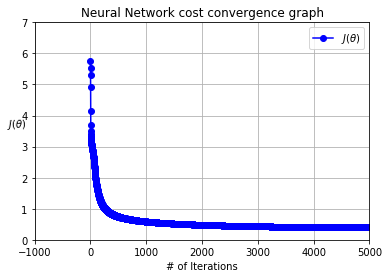

In [23]:
nnLearningCurve(cost_vec) # calling the function to plot the learning curve

**2.9 - Making NN Prediction**

After training the neural network, we would like to use it to the labels. We will now implement the `predict()` function to use the neural network to predict the labels of the training set. This lets us compute the training set accuracy of our classifier by computing the percentage of examples it got correct..

In [24]:
def predict(X, parameters):
    
    A3, cache = feedForward(X,parameters)
    prediction = np.argmax(A3, axis=1);
    prediction = prediction + 1;
    
    return prediction

Let us now call the `predict()` function to compute the training accuracy..

In [25]:
prediction = predict(X_train, parameters)
correct = [1 if a == b else 0 for (a, b) in zip(prediction, y_train)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('\nTraining Accuracy = %.2f' % (accuracy * 100)+'%\n')


Training Accuracy = 98.26%



**3 - Visualizing the hidden layer**

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value close to 1) 

For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden units. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the \representation" captured by the hidden unit is to reshape this 400 dimensional vector into a 20 x 20 image and display it

In [26]:
# PROCESS TO REMOVE THE BIAS IN ORDER TO VISUALIZE THE HIDDEN LAYER 
W1 = parameters["W1"] # The updated weight from backpropagation algorithm
hidden_W1 = W1[:,1:]  # Creating a temp variable to remove the 0th entry for the bias

# RESULTS CHECK
print('\ni. Theta1[with the bias]:\n       Rows: %d, columns: %d' % (W1.shape[0], W1.shape[1])+'\n')
print('ii. Theta1[without the bias]:\n       Rows: %d, columns: %d' % (hidden_W1.shape[0], hidden_W1.shape[1]))


i. Theta1[with the bias]:
       Rows: 25, columns: 401

ii. Theta1[without the bias]:
       Rows: 25, columns: 400



Visualizing hidden layer  ...



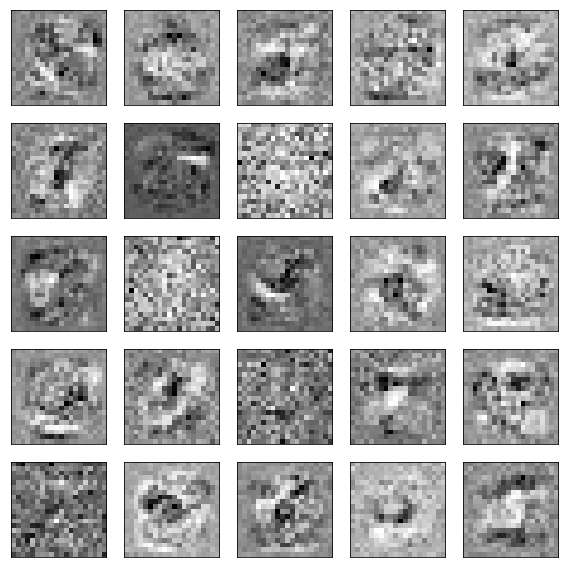

In [27]:
def visualizeHiddenLayer(x):
    fig, ax = plt.subplots(nrows =5, ncols=5,figsize=(8,8),sharex=True, sharey=True)
    ax = ax.flatten()
    (m,n) = x.shape
    print("\nVisualizing hidden layer  ...\n")
    for i in range(m):
        img = x[i,:].reshape(20,20,order="F")
        ax[i].imshow(img, cmap='Greys')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
# Calling visualizeHiddenLayer(x) function
visualizeHiddenLayer(hidden_W1)